# Extracting and implementing structural features of winning tickets

This notebook has the following parts:
* Prerequisites
* Extracting conv1 weight matrices from model 
* Extracting structural features from matrices
* Extracting structural features from Isables Winning Tickets
* Implementing structural features at initialization

## Prerequisites:

In [1]:
# import necessary libraries

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import copy

In [2]:
def load_and_prep_cifar(batch_size, shuffle_size):
    # load data set
    (train_ds, test_ds), ds_info = tfds.load(name="cifar10", split=["train","test"], as_supervised=True, with_info=True)
    # tfds.show_examples(train_ds, ds_info)
    
    def prepare_cifar10_data(ds):
        #convert data from uint8 to float32
        ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
        #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
        ds = ds.map(lambda img, target: ((img/128.)-1., target))
        #create one-hot targets
        ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
        #cache this progress in memory, as there is no need to redo it; it is deterministic after all
        ds = ds.cache()
        #shuffle, batch, prefetch
        ds = ds.shuffle(shuffle_size).batch(batch_size).prefetch(2)
        #return preprocessed dataset
        return ds
    
    # prepare data
    train_dataset = train_ds.apply(prepare_cifar10_data)
    test_dataset = test_ds.apply(prepare_cifar10_data)
    
    return train_dataset, test_dataset

In [3]:
# create the model

class CNN2Model(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
            
    
    def get_conv_weights(self):
        return self.conv1.get_weights(), self.conv2.get_weights(), self.dense3.get_weights()
        
    def set_conv_weights(self,weights_conv1, weights_conv2, weights_dense3):
        self.conv1.set_weights(weights_conv1)
        self.conv2.set_weights(weights_conv2)
        self.dense3.set_weights(weights_dense3)
        
    def get_dense_weights(self):
        return self.dense1.get_weights(), self.dense2.get_weights()
        
    def set_dense_weights(self,weights_dense1, weights_dense2):
        self.dense1.set_weights(weights_dense1)
        self.dense2.set_weights(weights_dense2)

## Extracting conv1 weight matrices from model

In [4]:
# function to extract weight matrix of conv1 layer in practical format

def get_conv1_weights(model):
    # get kernels of the conv1 layer in a neet numpy array and extract pruning rate
    conv1_weights = model.get_conv_weights()[0][0]  # shape=[3,3,3,64]
    conv1_weights_t = np.transpose(conv1_weights, (3, 0, 1, 2)) # shape=[64,3,3,3]
    return conv1_weights_t

In [5]:
# function to load and collect the conv1 kernels of multiple networks in one numpy array

def get_and_load_conv1_weights(files):
    # initialize a model
    train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
    model = CNN2Model()
    model(list(train_dataset)[0][0])
    # load isabels stored weights into model and extract numpy weight matrix of conv1 layer
    all_kernels = None
    first_set = True
    for file in files:
        model.load_weights(file)
        conv1_weights = get_conv1_weights(model)
        # concatenate kernels of each model
        if first_set:
            all_kernels = conv1_weights
            first_set = False
        else:
            all_kernels = np.concatenate((all_kernels,conv1_weights), axis=0)
    return all_kernels

## Extracting structural features from matrices

In [6]:
# calculate the pruning rate (the ratio of non-zero elements) of a weight matrix 
# (or multiple weight matrices collectively)
def get_pruning_rate(weights):
    int_weights = []
    for w in weights:
        int_weights.extend(w.astype(bool).astype(int).flatten())
    pruning_rate = np.mean(int_weights)
    print(f"The pruning rate is {pruning_rate}, so {1 - pruning_rate} of the weights have been set to zero.")
    return pruning_rate

In [7]:
# calculate the positional probabilities of unpruned weights in a kernel
def get_pos_probs(kernels):
    pos_probs = np.mean(kernels.astype(bool).astype(int), axis=0)
    print("The probabilites for each position in the kernel to be unpruned: \n",pos_probs)
    return pos_probs

# extract distribution of signs
def get_sign_ratio(kernels):
    pos_values = len(kernels.flatten()[kernels.flatten()>0.0])
    neg_values = len(kernels.flatten()[kernels.flatten()<0.0])
    ratio = pos_values/neg_values
    print(f"There are {pos_values} positive weights and {neg_values} negative weights. Therfore the sign ratio is {ratio}.")
    return ratio

# extract distribution of number of weights per kernel
def get_weight_distr(kernels):
    # for each kernel, count the number of unpruned weights
    distribution = [0]*(3*3*3+1)
    numbers = range(3*3*3+1)
    for kernel in kernels:
        number_weights = np.sum(kernel.astype(bool).astype(int))
        distribution[number_weights] = distribution[number_weights] + 1
    # turn the distribution into probability distributioin
    distribution = distribution / np.sum(distribution)
    # plot distribution
    plt.bar(numbers,distribution)
    plt.xlabel('number of unpruned weights per kernel')  
    plt.ylabel('probability')  
    plt.title('probability distribution of pruning rate over kernels')  
    plt.show()
    return distribution

## Extracting structural features from Isables Winning Tickets

Right now using all winning tickets form Isabel, probabbly including those that were not succesfull.

In [8]:
# a list of the names of the winning ticket files from Isabels GitHub
def wt_file_names(numbers=5):
    names = []
    for n in range(numbers):
        names.append(f"isabels_wts/WT_s0.1_nr{n}.h5")
    return names

The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.2890625  0.30234375 0.3       ]
  [0.309375   0.2875     0.31875   ]
  [0.30859375 0.31875    0.346875  ]]

 [[0.315625   0.31328125 0.3609375 ]
  [0.296875   0.31640625 0.32109375]
  [0.315625   0.33125    0.3453125 ]]

 [[0.278125   0.28671875 0.32734375]
  [0.32578125 0.3109375  0.321875  ]
  [0.2921875  0.31015625 0.31796875]]]
There are 7037 positive weights and 3803 negative weights. Therfore the sign ratio is 1.8503812779384696.


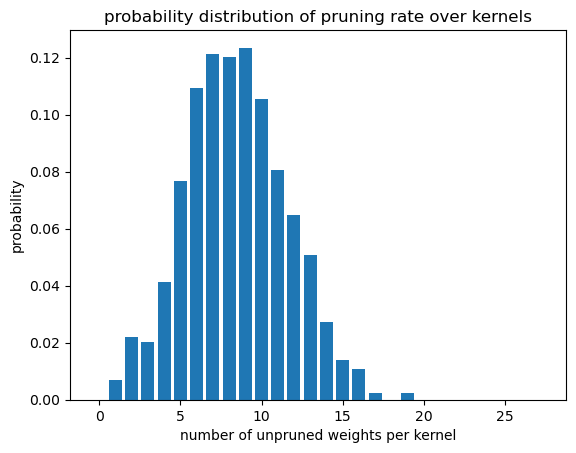

In [9]:
# Extracting structural features form Isables generated winning tickets

file_names = wt_file_names(20)
wt_kernels = get_and_load_conv1_weights(file_names)
wt_pruning_rate = get_pruning_rate(wt_kernels)
wt_pos_probs = get_pos_probs(wt_kernels)
wt_sign_ratio = get_sign_ratio(wt_kernels)
wt_weight_distr = get_weight_distr(wt_kernels)

## Implementing structural features at initialization

In [10]:
# implement random pruning of a weight matrix according to a pruning rate
def random_pruning(kernels_m, pruning_rate):
    kernels = copy.copy(kernels_m)
    shape = np.shape(kernels)
    kernels = kernels.flatten()
    # caclulate how many weights need to be pruned
    pruning_number = int((1-pruning_rate) * len(kernels))
    # choose accordingly a random selection of weights to get pruned
    pruning_indexi = random.sample(range(len(kernels)),pruning_number)
    kernels[pruning_indexi] = 0.0
    kernels = np.reshape(kernels,shape)
    return kernels

# adapt signs in a weight matrix such that it fullfills a certain sign ratio
def sign_ratio_adaption(kernels_m, sign_ratio):
    kernels = copy.copy(kernels_m)
    shape = np.shape(kernels)
    kernels = np.abs(kernels.flatten())
    # get indexi of all unpruned weights
    indexi_unpruned = []
    for index, w in enumerate(kernels):
        if w > 0:
            indexi_unpruned.append(index)
    # calculate the number of weights that shall have a negative sign according to sign ratio
    number_neg = int(len(indexi_unpruned) * (1 / (1+1.9)))
    # choose randomly those weights which get a negative sign
    neg_indexi = random.sample(indexi_unpruned,number_neg)
    kernels[neg_indexi] = kernels[neg_indexi] * -1
    kernels = np.reshape(kernels,shape)
    return kernels

# prune kernels according to positional distribution for each kernel position to not be pruned
def pos_prob_pruning(kernels_m, pos_probs):
    kernels = copy.copy(kernels_m)
    # for each position in kernel
    for i in range(3):
        for j in range(3):
            for k in range(3):
                # get pruning probability and prune accordingly across channels
                position = kernels[:,i,j,k]
                nbr_to_prune = round((1-pos_probs[i,j,k]) * len(position))
                pruning_indexi = random.sample(range(len(position)),nbr_to_prune)
                position[pruning_indexi] = 0.0
                kernels[:,i,j,k] = position
    return kernels

# prune a matrix according to the distribution of how many weights remain in each kernel after pruning
# by sampling the distribution
def weight_distr_pruning(kernels_m, weight_distr):
    kernels = copy.copy(kernels_m)
    # sample from weight distribution and collect the resulting weights per kernel choices in an array
    # sample by sampling from uniform distribution and using cumulative probability of weight distribution 
    # as decision boundaries
    nbr_weights_all = []
    for kernel in kernels:
        nbr_weights = 0
        cum_probability = weight_distr[nbr_weights]
        prob_sample = np.random.uniform()
        while prob_sample > cum_probability:
            nbr_weights += 1
            cum_probability += weight_distr[nbr_weights]
        nbr_weights_all.append(nbr_weights)
    # prune each kernel respectively
    new_kernels = []
    for unpruned_nbr,kernel in zip(nbr_weights_all,kernels):
        shape = np.shape(kernel)
        kernel = kernel.flatten()
        nbr_to_prune = 3*3*3 - unpruned_nbr
        pruning_indexi = random.sample(range(len(kernel)),nbr_to_prune)
        kernel[pruning_indexi] = 0.0
        new_kernels.append(np.reshape(kernel,shape))
    return np.array(new_kernels)

# prune a matrix according to the distribution of how many weights remain in each kernel after pruning
# without sampling from the distribution
def weight_distr_pruning_deterministic(kernels_m, weight_distr):
    kernels = copy.copy(kernels_m)
    # use the distribution to choose how many kernels to prune how much
    nbr_kernels = kernels.shape[0]
    unpruned_nbrs = []
    for unpruned_nbr, probability in enumerate(weight_distr):
        unpruned_nbrs.extend([unpruned_nbr] *  round(probability*nbr_kernels))
    # sort pruning numbers randomly to the kernels
    random.shuffle(unpruned_nbrs)
    # prune each kernel respectively
    new_kernels = []
    for unpruned_nbr,kernel in zip(unpruned_nbrs,kernels):
        shape = np.shape(kernel)
        kernel = kernel.flatten()
        nbr_to_prune = 3*3*3 - unpruned_nbr
        pruning_indexi = random.sample(range(len(kernel)),nbr_to_prune)
        kernel[pruning_indexi] = 0.0
        new_kernels.append(np.reshape(kernel,shape))
    return np.array(new_kernels)

---------------------------------
 unpruned net statistics: 
---------------------------------
The pruning rate is 1.0, so 0.0 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
There are 866 positive weights and 862 negative weights. Therfore the sign ratio is 1.0046403712296983.


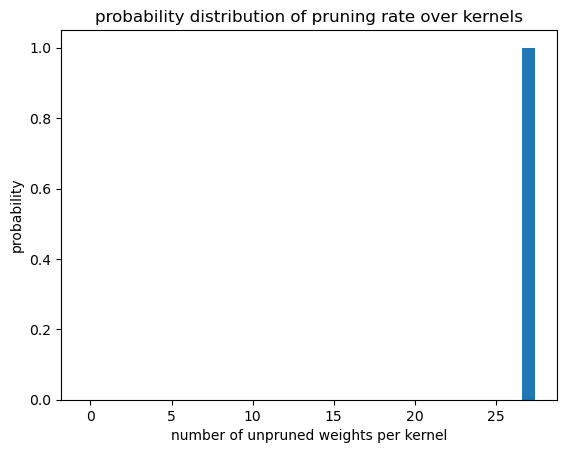

---------------------------------
 random sparse net statistics: 
---------------------------------
The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.3125   0.375    0.265625]
  [0.3125   0.3125   0.3125  ]
  [0.328125 0.25     0.359375]]

 [[0.28125  0.296875 0.359375]
  [0.359375 0.203125 0.28125 ]
  [0.328125 0.296875 0.234375]]

 [[0.25     0.34375  0.234375]
  [0.359375 0.375    0.28125 ]
  [0.359375 0.421875 0.375   ]]]
There are 264 positive weights and 278 negative weights. Therfore the sign ratio is 0.9496402877697842.


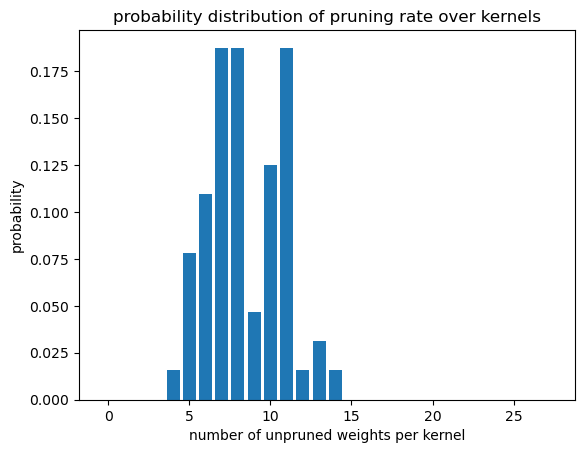

---------------------------------
 sign adapted net statistics: 
---------------------------------
The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.28125  0.25     0.34375 ]
  [0.4375   0.25     0.296875]
  [0.296875 0.359375 0.234375]]

 [[0.28125  0.328125 0.359375]
  [0.265625 0.3125   0.25    ]
  [0.28125  0.3125   0.359375]]

 [[0.265625 0.390625 0.359375]
  [0.25     0.28125  0.375   ]
  [0.296875 0.34375  0.40625 ]]]
There are 356 positive weights and 186 negative weights. Therfore the sign ratio is 1.913978494623656.


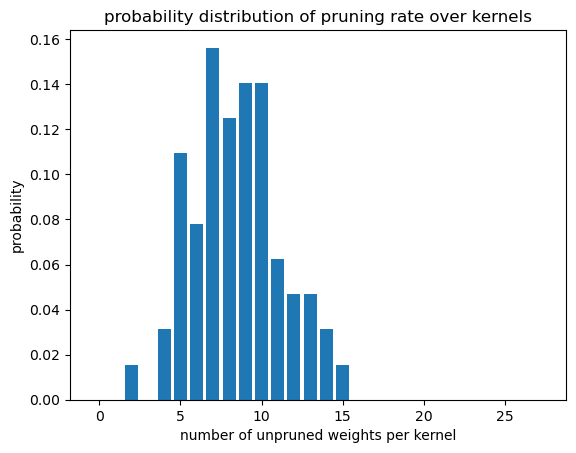

---------------------------------
 positionaly pruned net statistics: 
---------------------------------
The pruning rate is 0.3125, so 0.6875 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.28125  0.296875 0.296875]
  [0.3125   0.28125  0.3125  ]
  [0.3125   0.3125   0.34375 ]]

 [[0.3125   0.3125   0.359375]
  [0.296875 0.3125   0.328125]
  [0.3125   0.328125 0.34375 ]]

 [[0.28125  0.28125  0.328125]
  [0.328125 0.3125   0.328125]
  [0.296875 0.3125   0.3125  ]]]
There are 252 positive weights and 288 negative weights. Therfore the sign ratio is 0.875.


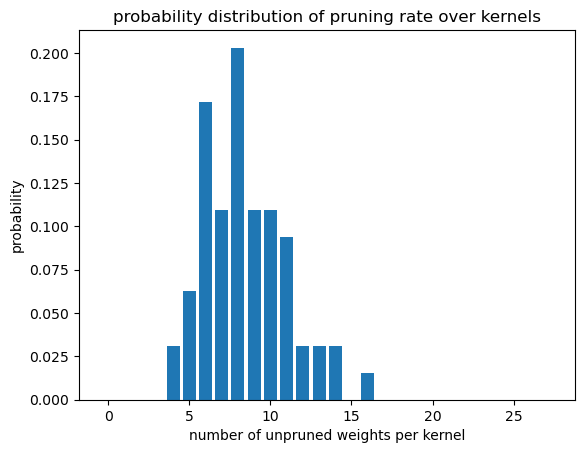

---------------------------------
 weight distribution pruned net statistics: 
---------------------------------
The pruning rate is 0.3287037037037037, so 0.6712962962962963 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.25     0.34375  0.390625]
  [0.375    0.296875 0.28125 ]
  [0.390625 0.25     0.265625]]

 [[0.375    0.203125 0.28125 ]
  [0.40625  0.453125 0.3125  ]
  [0.296875 0.34375  0.296875]]

 [[0.46875  0.3125   0.328125]
  [0.421875 0.3125   0.28125 ]
  [0.296875 0.28125  0.359375]]]
There are 278 positive weights and 290 negative weights. Therfore the sign ratio is 0.9586206896551724.


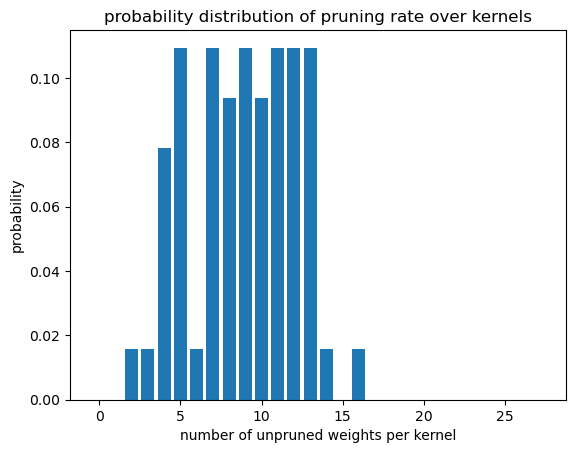

---------------------------------
 weight distribution deterministically pruned net statistics: 
---------------------------------
The pruning rate is 0.31655092592592593, so 0.6834490740740741 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.28125  0.234375 0.3125  ]
  [0.3125   0.328125 0.3125  ]
  [0.359375 0.390625 0.28125 ]]

 [[0.296875 0.390625 0.265625]
  [0.265625 0.4375   0.34375 ]
  [0.28125  0.28125  0.359375]]

 [[0.3125   0.34375  0.34375 ]
  [0.3125   0.296875 0.390625]
  [0.265625 0.296875 0.25    ]]]
There are 270 positive weights and 277 negative weights. Therfore the sign ratio is 0.9747292418772563.


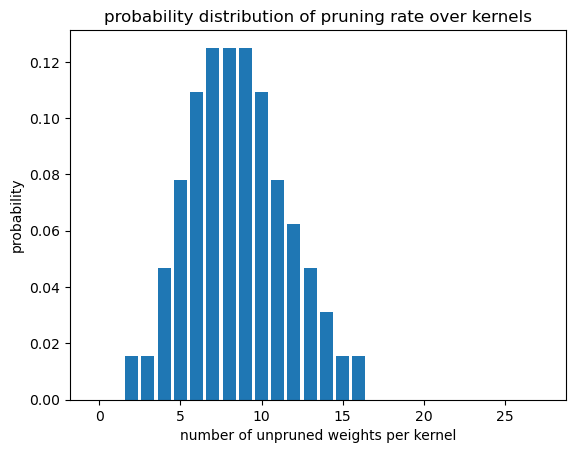

In [11]:
# Testing functions for implementing structural features of winning tickets

# initialize a model randomly
train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
model = CNN2Model()
model(list(train_dataset)[0][0])

# get statistics of random not-sparse net
print("---------------------------------\n unpruned net statistics: \n---------------------------------")
unpruned_kernels = get_conv1_weights(model)
up_pruning_rate = get_pruning_rate(unpruned_kernels)
up_pos_probs = get_pos_probs(unpruned_kernels)
up_sign_ratio = get_sign_ratio(unpruned_kernels)
up_weight_distr = get_weight_distr(unpruned_kernels)

# get statistics of random sparse net
print("---------------------------------\n random sparse net statistics: \n---------------------------------")
pruned_kernels = random_pruning(unpruned_kernels, wt_pruning_rate)
rs_pruning_rate = get_pruning_rate(pruned_kernels)
rs_pos_probs = get_pos_probs(pruned_kernels)
rs_sign_ratio = get_sign_ratio(pruned_kernels)
rs_weight_distr = get_weight_distr(pruned_kernels)

# implementing wt sign ratio
print("---------------------------------\n sign adapted net statistics: \n---------------------------------")
pruned_kernels = random_pruning(unpruned_kernels, wt_pruning_rate)
sign_adapted_kernels = sign_ratio_adaption(pruned_kernels, wt_sign_ratio)
sa_pruning_rate = get_pruning_rate(sign_adapted_kernels)
sa_pos_probs = get_pos_probs(sign_adapted_kernels)
sa_sign_ratio = get_sign_ratio(sign_adapted_kernels)
sa_weight_distr = get_weight_distr(sign_adapted_kernels)

# implementing wt positional probabilities
print("---------------------------------\n positionaly pruned net statistics: \n---------------------------------")
pos_pruned_kernels = pos_prob_pruning(unpruned_kernels, wt_pos_probs)
pp_pruning_rate = get_pruning_rate(pos_pruned_kernels)
pp_pos_probs = get_pos_probs(pos_pruned_kernels)
pp_sign_ratio = get_sign_ratio(pos_pruned_kernels)
pp_weight_distr = get_weight_distr(pos_pruned_kernels)

# implementing wt weight distribution
print("---------------------------------\n weight distribution pruned net statistics: \n---------------------------------")
weight_distr_pruned_kernels = weight_distr_pruning(unpruned_kernels, wt_weight_distr)
wdp_pruning_rate = get_pruning_rate(weight_distr_pruned_kernels)
wdp_pos_probs = get_pos_probs(weight_distr_pruned_kernels)
wdp_sign_ratio = get_sign_ratio(weight_distr_pruned_kernels)
wdp_weight_distr = get_weight_distr(weight_distr_pruned_kernels)

# implementing wt weight distribution (deterministic version)
print("---------------------------------\n weight distribution deterministically pruned net statistics: \n---------------------------------")
weight_distr_det_pruned_kernels = weight_distr_pruning_deterministic(unpruned_kernels, wt_weight_distr)
wddp_pruning_rate = get_pruning_rate(weight_distr_det_pruned_kernels)
wddp_pos_probs = get_pos_probs(weight_distr_det_pruned_kernels)
wddp_sign_ratio = get_sign_ratio(weight_distr_det_pruned_kernels)
wddp_weight_distr = get_weight_distr(weight_distr_det_pruned_kernels)

## Building networks of 6 different conditions

In [12]:
# function to prune all other layers of a random network according to a set of pruning ratios

# gets a list of the individual pruning rates for each layer
def get_pruning_rates(model):
    p_rates = []
    weights = model.get_weights()
    for w_matrix in weights[::2]:
        p_rate = get_pruning_rate(w_matrix)
        p_rates.append(p_rate)
    return p_rates

# prunes each layer of a model individually according to a list of pruning rates
def all_layers_pruning(model, pruning_rates):
    weights = model.get_weights()
    pruned_weights = []
    for w_matrix, p_rate in zip(weights[::2],pruning_rates):
        pruned_matrix = random_pruning(w_matrix,p_rate)
        pruned_weights.append(pruned_matrix)
    weights[::2] = pruned_weights
    model.set_weights(weights)
    return model

In [13]:
# get the complete pruning rates of isabels winning tickets

train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
model = CNN2Model()
model(list(train_dataset)[0][0])
model.load_weights("isabels_wts/WT_s0.1_nr0.h5")

wt_pruning_rates = get_pruning_rates(model)

The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The pruning rate is 0.3138020833333333, so 0.6861979166666667 of the weights have been set to zero.
The pruning rate is 0.08590006828308105, so 0.914099931716919 of the weights have been set to zero.
The pruning rate is 0.085906982421875, so 0.914093017578125 of the weights have been set to zero.
The pruning rate is 0.0859375, so 0.9140625 of the weights have been set to zero.


In [ ]:
# one list of models per condition
all_nets = [[],[],[],[],[],[],[]]
all_conditions = ["random_pruned","pos_pruned","weight_distr_pruned","sa_random_pruned","sa_pos_pruned","sa_weight_distr_pruned", "wt_directly"]

NBR_MODELS = 10
for n in range(NBR_MODELS):
    
    # get an initial weight configuration of a model
    model = CNN2Model()
    model(list(train_dataset)[0][0])
    weights = model.get_weights()
    conv1_weights = get_conv1_weights(model)
    
    # prune layers 2-5 of the model
    pruned_weights = []
    for w_matrix, p_rate in zip(weights[2::2],wt_pruning_rates[1:]):
        pruned_matrix = random_pruning(w_matrix,p_rate)
        pruned_weights.append(pruned_matrix)
    weights[2::2] = pruned_weights
    
    all_conv1 = []
    
    # prune the conv1 layer of model in 3 different ways
    all_conv1.append(random_pruning(conv1_weights, wt_pruning_rate))
    all_conv1.append(pos_prob_pruning(conv1_weights, wt_pos_probs))
    all_conv1.append(weight_distr_pruning_deterministic(conv1_weights, wt_weight_distr))
    
    # make a sign ratio adapted version on each of them
    all_conv1.append(sign_ratio_adaption(all_conv1[0], wt_sign_ratio))
    all_conv1.append(sign_ratio_adaption(all_conv1[1], wt_sign_ratio))
    all_conv1.append(sign_ratio_adaption(all_conv1[2], wt_sign_ratio))
    
    # use conv1 layers directly extracted from the winning tickets
    all_conv1.append(wt_kernels[64*n:64*(n+1)])

    # save 7 different versions of each model (each with a different conv1 layer) in the corresponding condition lists
    for i, conv1 in enumerate(all_conv1):
        model = CNN2Model()
        model(list(train_dataset)[0][0])
        weights[0] = np.transpose(conv1, (1, 2, 3, 0))
        model.set_weights(weights)
        all_nets[i].append(model)
    

## Comparing training performance of the networks

In [ ]:
# train loop for sparse networks

def train_loop_sparse(train, test, model, num_epochs):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for e in tqdm(range(num_epochs)):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            # set gradients to zero for all pruned weights
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = np.where(variables == 0.0, 0.0, gradient_matrix)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  train_acc, test_acc, train_l, test_l

In [ ]:
train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
EPOCHS = 10

# train each model of each condition and plott all accuracies in one graph
all_accuracies = []
for models, condition in zip(all_nets,all_conditions):
    
    accuracies = []
    mean_accuracie = 0
    
    # train all the models of one condition and save the resulting accuracy (shape = [epochs])
    print(f"Training {NBR_MODELS} networks for {EPOCHS} epochs each for condition {condition}:")
    for model in models:
        train_acc, test_acc, train_l, test_l = train_loop_sparse(train_dataset, test_dataset, model, EPOCHS)
        mean_accuracie = mean_accuracie + (np.asarray(test_acc) / len(models))
        accuracies.append(np.asarray(test_acc))
        
    # turn the accuracies to a 2 dimensional array (shape = [model,epoch])
    accuracies = np.stack(accuracies)
    all_accuracies.append(accuracies)
    
    # add mean accuracies of the current condition to plot
    plt.plot(mean_accuracie, label=condition)

# get the complete set of measured accuracies (shape = [condition,model,epoch]) and save in file
all_accuracies = np.stack(all_accuracies)
print("shape all accuracies: ", all_accuracies.shape)
np.save("experiment_accuracies", all_accuracies)

    
# show the plot with the mean accuracies
plt.legend()
plt.xlabel('epochs')  
plt.ylabel('accuracy')  
plt.title('Testing accuracies for each type of conv1 layer') 
plt.show()